---
title: EpigenomeXcan test on Br rats
author: Sabrina Mi
date: 7/10/2024
description: Calculate associations between predicted gene expression in adipose tissue and BMI to identify significant gene, while I figure out high to scale up predicting epigenome step.
---

CPU times: 

1. Compute founders matrix (n_genes, 8)
    * 3190 genes: ~110s
2. Compute samples matrix (n_samples, n_genes, 8):
    * 3190 genes, 1 sample: ~4s
    * 3190 genes, 10 samples: ~40s

GPU times, combined steps 1 & 2:
1. Old code
    * 3190 genes, 340 samples: 32 minutes
2. New code removing inner foor loop
    * 1592 genes, 340 samples: 2 min 30 sec
    * 1575 genes, 340 samples: 2 min 5 sec
    * 19696 genes, 340 samples: 22 min 30 sec

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import h5py
import os
import time
import bisect
columns = ['ACI', 'BN', 'BUF', 'F344', 'M520', 'MR', 'WKY', 'WN']

2025-08-17 21:10:06.646981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-17 21:10:09.958339: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /soft/perftools/darshan/darshan-3.4.4/lib:/opt/cray/pe/papi/7.0.1.2/lib64:/opt/cray/libfabric/1.15.2.0/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/23.9/comm_libs/nvshmem/lib:/opt/nvidia/hpc_sdk/Linux_x86_64/23.9/comm_libs/nccl/lib:/opt/nvidia/hpc_sdk/Linux_x86_64/23.9/math_libs/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/23.9/compilers/lib:/opt/nvidia/hpc_sdk/Linux_x86_64/23.9/compilers/extras/qd/lib:/op

In [3]:
gene_annot = pd.read_csv("/eagle/AIHPC4Edu/sabrina/Br_predictions/HS_founder_epigenomes/gene_mapping.txt")
gene_annot = gene_annot[~gene_annot['chromosome'].isin(['chrX', 'chrY'])]
genes_by_chrom = gene_annot.groupby('chromosome')

In [6]:
probabilities_dir = "/eagle/AIHPC4Edu/sabrina/Br_genotype_probabilities"
reference_dir = "/eagle/AIHPC4Edu/sabrina/Br_predictions/HS_founder_epigenomes/human"
output_dir = "/eagle/AIHPC4Edu/sabrina/Br_prediction_from_founders"

Realizing my haplotype probabilities storage is redundant, taking up extra space.

In [ ]:
#| code-fold: true
probabilities_file = f'{probabilities_dir}/chr20_probabilities.h5'
with h5py.File(probabilities_file, 'a') as hf:
    for dataset_name in list(hf.keys()):
        if hf[dataset_name].shape[1] == 8:
            continue
        elif hf[dataset_name].shape[1] == 9:
            # Read the dataset
            data = hf[dataset_name][:]
            positions = data[:, 0]  # Assuming the positions column is the first column
            new_data = data[:, 1:]  # All columns except the first one
            
            # Create a temporary dataset without the positions column
            temp_dataset_name = f"temp_{dataset_name}"
            hf.create_dataset(temp_dataset_name, data=new_data)
            
            # Delete the original dataset
            del hf[dataset_name]
        
            # Rename the temporary dataset to the original dataset name
            hf.move(temp_dataset_name, dataset_name)
        
    hf.create_dataset('positions', data=positions)
        # Store the positions vector as metadata (attribute) for the dataset



split genes by chromosome number
for individual, query haplotype probabilities at each gene tss, so we return an 8 x n_gene matrix. by batching by genes n_genes should be in the 1-2K range. stack to return a 3d array with dimensions n_samples x 8 x n_gene
next query reference epigenome at each gene [446:450, CAGE_index], return 8 x n_gene matrix
matrix multiply with something like tf.transpose(tf.tensordot(_W, _X, axes=[[1],[1]]),[1,0,2])
https://stackoverflow.com/questions/41870228/understanding-tensordot

In [9]:
def reference_epigenome_matrix(chr, genes_df, track = 5278):
    reference_file = f'{reference_dir}/{chr}_genes.h5'
    with h5py.File(reference_file, 'r') as ref:
        rows = []
        for gene in genes_df['gene']:
            founder_predictions = ref[gene][:, 446:450, track]
            rows.append(founder_predictions)
        ref_matrix = np.stack(rows, axis=0)
        ref_tensor = tf.reduce_mean(tf.convert_to_tensor(ref_matrix, dtype=tf.float32), axis=2)
        return ref_tensor

In [10]:
def probabilities_matrix(chr, genes_df, individuals):
    probabilities_file = f'{probabilities_dir}/{chr}_probabilities.h5'
    with h5py.File(probabilities_file, 'r') as prob:
        positions = prob['positions'][:]
        population_prob = []
        indices = []
        for tss in genes_df['tss']:
            index = bisect.bisect_left(positions, tss)
            if index == 0:
                indices += [0,0]
            elif index == len(positions):
                indices += [index-1,index-1]
            else: # 0 < index < len(positions)
                indices += [index-1, index]
        for sample in individuals:
            dataset = prob[sample][:]
            sample_prob = tf.convert_to_tensor(dataset[indices], dtype = tf.float32)
            sample_prob = tf.reshape(sample_prob, (-1, 2, sample_prob.shape[1]))
            sample_prob = tf.reduce_mean(sample_prob, axis=1)
            population_prob.append(sample_prob)
        prob_tensor = tf.stack(population_prob, axis=0)
        return prob_tensor

In [11]:
def predict_epigenome(chr, genes_df, individuals, output_file, track):
    ref_tensor = reference_epigenome_matrix(chr, genes_df, track)
    prob_tensor = probabilities_matrix(chr, genes_df, individuals)
    epigenome_tensor = tf.einsum('ijk,jk->ij', prob_tensor, ref_tensor)
    epigenome_df = pd.DataFrame(epigenome_tensor.numpy(), columns=genes_df['gene'], index = individuals)
    epigenome_df.to_csv(output_file)


In [7]:
with open('/eagle/AIHPC4Edu/sabrina/Br_genotype_probabilities/individuals.txt', 'r') as f:
    individuals = f.read().splitlines()
#pheno = pd.read_csv('/home/s1mi/enformer_rat_data/phenotypes/pheno.fam', sep = '\t', index_col = 'IID')

## Example with CAGE Brain

### Predict Expression using Fast Enformer

In [ ]:
for chr, genes_df in genes_by_chrom:
    tic = time.perf_counter()
    predict_epigenome(chr, genes_df, individuals, f'{output_dir}/{chr}_CAGE_brain__predict.txt', track = 4980)
    toc = time.perf_counter()
    print(f'{chr}, {len(genes_df)} genes:', toc - tic, 'seconds')

In [2]:
all_pheno = pd.read_csv("/home/s1mi/enformer_rat_data/phenotypes/ALLTRAITSALLNORMALIZES_19jul24.csv", 
                        usecols = ['rfid', 'dissection:regressedlr_length_w_tail_cm', 'dissection:regressedlr_bmi_w_tail'],
                        index_col = 'rfid')
all_pheno.columns = ['bodylen', 'bmi']
pheno = all_pheno[all_pheno['bodylen'].notna()]
pheno_samples = list(pheno.index)

/tmp/ipykernel_2837064/4138209945.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  all_pheno = pd.read_csv("/home/s1mi/enformer_rat_data/phenotypes/ALLTRAITSALLNORMALIZES_19jul24.csv",


In [7]:
pred_expr = pd.read_csv(f'{output_dir}/Br_all_genes_by_tissue/Br_CAGE_brain__predict.txt', index_col=0)
samples = pred_expr.index.intersection(pheno_samples)
print(f'{len(samples)} samples in association test')

324 samples in association test


We write new predicted expression and phenotype files with the same order of individuals.

In [8]:
pred_expr = pred_expr.loc[samples]
pheno = pheno.loc[samples]

In [ ]:
pred_expr.insert(loc=0, column="FID", value=pred_expr.index)
pred_expr.insert(loc=1, column="IID", value=pred_expr.index)
pred_expr.to_csv("Br_CAGE_brain__predict.txt", sep="\t", index=False, header=True)
pheno.to_csv("Br_bodylen_bmi.txt", sep="\t", index=False, header=True)

### Run Association

```
module use /soft/modulefiles
module load conda
conda activate imlabtools

METAXCAN=~/Github/MetaXcan/software

# Bodylength Association
python3 $METAXCAN/PrediXcanAssociation.py \
--expression_file Br_CAGE_brain__predict.txt \
--input_phenos_file Br_bodylen_bmi.txt \
--input_phenos_column bodylen \
--output Br_CAGE_brain_bodylen__association.txt \
--verbosity 9 \
--throw

# BMI Association
python3 $METAXCAN/PrediXcanAssociation.py \
--expression_file Br_CAGE_brain__predict.txt \
--input_phenos_file Br_bodylen_bmi.txt \
--input_phenos_column bmi \
--output Br_CAGE_brain_bmi__association.txt \
--verbosity 9 \
--throw
```

### Compare Results to RatXcan

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
colors = sns.color_palette("pastel")


#### Body length

In [131]:
bodylen_assoc = pd.read_csv("Br_CAGE_brain_bodylen__association.txt", usecols=['gene','zscore','pvalue'], sep="\t")
bodylen_results = pd.read_csv("/home/s1mi/PrediXcan/Results/ratxcan-bodylen-results.csv", usecols = ['gene_name', 'gene', 'p_acat_5'])
bodylen_merged = pd.merge(bodylen_results, bodylen_assoc, on="gene")

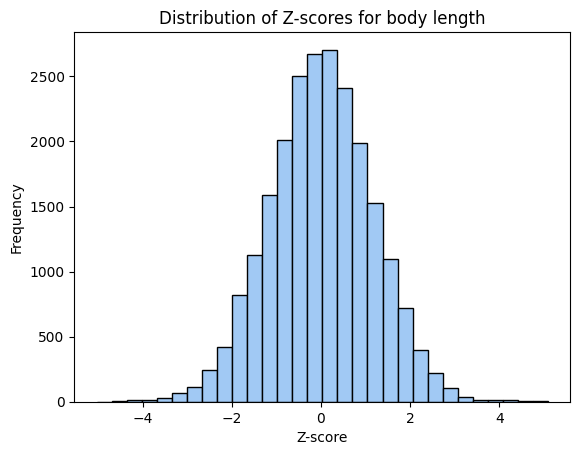

In [132]:
plt.hist(bodylen_assoc['zscore'], bins=30, edgecolor='black', color=colors[0])
plt.title('Distribution of Z-scores for body length')
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.show()

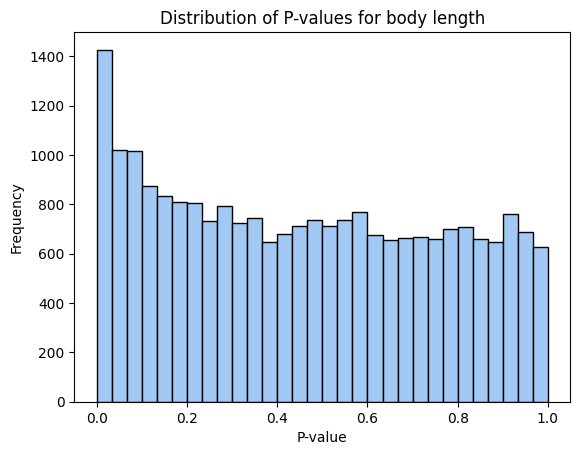

In [133]:
plt.hist(bodylen_assoc['pvalue'], bins=30, edgecolor='black', color=colors[0])
plt.title('Distribution of P-values for body length')
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.show()

In [140]:
threshold_FE = 0.5 / len(bodylen_assoc)
# Filter significant genes
bodylen_genes_FE = bodylen_assoc.loc[bodylen_assoc['pvalue'] < threshold_FE, 'gene']
print(f'{len(bodylen_genes_FE)} of {len(bodylen_assoc)} genes are Bonferroni significant using the Fast Enformer method.')
threshold_ratxcan = 0.5 / len(bodylen_results)
bodylen_genes_ratxcan = bodylen_results.loc[bodylen_results['p_acat_5'] < threshold_ratxcan, 'gene']
print(f'{len(bodylen_genes_ratxcan)} of {len(bodylen_results)} genes are Bonferroni significant using RatXcan.')

19 of 22876 genes are Bonferroni significant using the Fast Enformer method.
16 of 10933 genes are Bonferroni significant using RatXcan.


Unfortunately, the lists of genes found significant using Fast Enformer and RatXcan do not overlap.

#### BMI

In [141]:
bmi_assoc = pd.read_csv("Br_CAGE_brain_bmi__association.txt", usecols=['gene','zscore','pvalue'], sep="\t")
bmi_results = pd.read_csv("/home/s1mi/PrediXcan/Results/ratxcan-bmi-results.csv", usecols = ['gene_name', 'gene', 'p_acat_5'])
bmi_merged = pd.merge(bmi_results, bmi_assoc, on="gene")

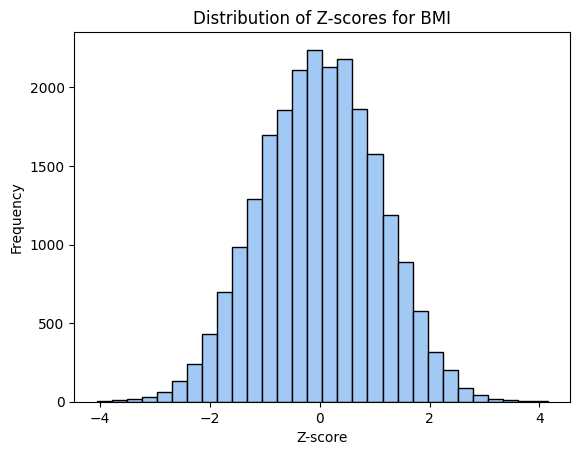

In [142]:
plt.hist(bmi_assoc['zscore'], bins=30, edgecolor='black', color=colors[0])
plt.title('Distribution of Z-scores for BMI')
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.show()

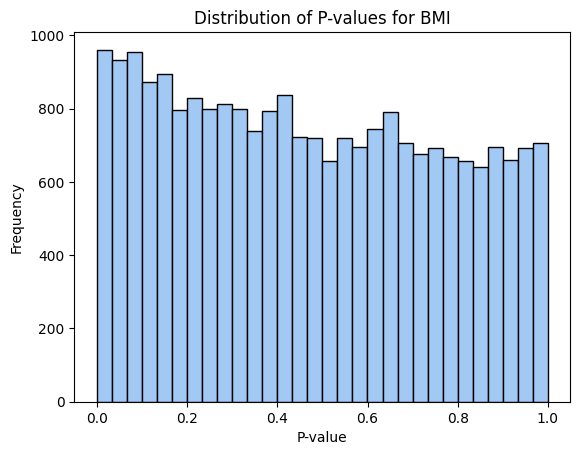

In [143]:
plt.hist(bmi_assoc['pvalue'], bins=30, edgecolor='black', color=colors[0])
plt.title('Distribution of P-values for BMI')
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.show()

In [144]:
threshold_FE = 0.5 / len(bmi_assoc)
# Filter significant genes
bmi_genes_FE = bmi_assoc.loc[bmi_assoc['pvalue'] < threshold_FE, 'gene']
print(f'{len(bmi_genes_FE)} of {len(bmi_assoc)} genes are Bonferroni significant using the Fast Enformer method.')
threshold_ratxcan = 0.5 / len(bmi_results)
bmi_genes_ratxcan = bmi_results.loc[bmi_results['p_acat_5'] < threshold_ratxcan, 'gene']
print(f'{len(bmi_genes_ratxcan)} of {len(bmi_results)} genes are Bonferroni significant using RatXcan.')

0 of 22876 genes are Bonferroni significant using the Fast Enformer method.
16 of 10933 genes are Bonferroni significant using RatXcan.
